### Sindicâncias e inquéritos administrativos na Corregedoria da Guarda Civil Metropolitana

**Autor:** Rodolfo Viana<br>
**Data de início:** 14 de março de 2018<br>
**Data de término:** 14 de março de 2018<br>
**Data de atualização:** 17 de abril de 2018<br>
**Motivo de atualização:** Inserção de gráficos<br>
**Fonte de dados:** Corregedoria da GCM<br>
**Coleta de dados:** Dois documentos `.pdf` -- um com dados de 2014 e 2015, e outro com dados de 2016 e 2017 -- obtidos via Lei de Acesso à Informação, em 5 de fevereiro de 2018<br>
**Arquivo de origem (convertido):** `gcm1.csv` e `gcm2.csv`<br>
**Ferramentas e bibliotecas:** Python 3.6, Jupyter, Pandas, Matplotlib, Seaborn

In [1]:
# Importação de ferramentas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Criação do primeiro dataset (2016 e 2017)
df1 = pd.read_csv('gcm1.csv', sep = ';', encoding = 'utf-8')
df1 = df1.drop('Dt Dos Fatos', axis = 1)

# Transformação das datas no padrão para análise
df1['DataAutuação'] = pd.to_datetime(df1['DataAutuação'])

# Renomeação das colunas
df1 = df1.rename(columns={
    'NºProc': 'num_processo', 
    'Tipo': 'tipo', 
    'DataAutuação': 'dt_autuacao', 
    'Penalidade Recebida': 'penalidade', 
    'Natureza': 'natureza'
})

# Criação dos campos 'ano_autuacao' e 'ano_fato' para futuras análises temporais
df1['ano_autuacao'] = df1['dt_autuacao'].dt.year

# Criação do segundo dataset (2014 e 2015)
df2 = pd.read_csv('gcm2.csv', sep = ';', encoding = 'latin-1')
df2 = df2.drop('Unnamed: 0', axis = 1)

# Renomeação da coluna
df2 = df2.rename(columns = {'dt_atuacao': 'dt_autuacao'})

# Transformação das datas no padrão para análise
df2['dt_autuacao'] = pd.to_datetime(df2['dt_autuacao'])
df2['ano_autuacao'] = df2['dt_autuacao'].dt.year

# Reorganização das colunas
df2 = df2[['num_processo', 'tipo', 'dt_autuacao', 'penalidade', 'natureza', 'ano_autuacao']]

# Criação do dataset
dataset = pd.concat([df1, df2])

# Tamanho do conjunto de dados
len(dataset)

1108

In [2]:
# Checagem de valor aleatório
dataset.iloc[43]

num_processo           201701547950
tipo                    SINDICÂNCIA
dt_autuacao     2017-09-10 00:00:00
penalidade             EM ANDAMENTO
natureza                   agressão
ano_autuacao                   2017
Name: 43, dtype: object

In [3]:
# Contagem dos tipos de processos
dataset['tipo'].value_counts()

SINDICÂNCIA                 794
INQUÉRITO ADMINISTRATIVO    314
Name: tipo, dtype: int64

Há 1.108 registros de sindicâncias e inquéritos administrativos instaurados entre 2014 e 2017. Desses:
    
    - 794 são sindicâncias
    - 314 são inquéritos

Devemos segmentar pela punição:

In [4]:
# Criação de uma coluna chamada 'punido' e preenchimento 
# de cada linha da coluna com 'Sim', 'Não' e 'Incerto' 
# (quando o resultado é a continuação do processo), de 
# acordo com a penalidade
punido = []

for row in dataset['penalidade']:
    if row == 'EM ANDAMENTO':
        punido.append('Incerto')        
    elif row == 'DECISÃO EM OUTRO PA':
        punido.append('Incerto')
    elif row == 'INQUÉRITO ADMINISTRATIVO':
        punido.append('Incerto')
    elif row == 'DADO PROVIMENTO':
        punido.append('Incerto')
    elif row == 'EXTINÇÃO POR PRESCRIÇÃO':
        punido.append('Não')
    elif row == 'ARQUIVAMENTO':
        punido.append('Não')
    elif row == 'ABSOLVIÇÃO':
        punido.append('Não')
    elif row == 'EXTINÇÃO SEM JULGAMENTO DO MÉRITO':
        punido.append('Não')
    elif row == 'EXTINÇÃO COM JULGAMENTO DO MÉRITO':
        punido.append('Não')
    elif row == 'DESCARACTERIZADO DO PROCESSO':
        punido.append('Não')
    elif row == 'SOBRESTADO':
        punido.append('Não') 
    elif row == 'ARQUIVAMENTO PELA DUPLICIDADE':
        punido.append('Não')
    elif row == 'EXTINÇÃO POR PRESCRIÇÃO':
        punido.append('Não') 
    elif row == 'ACOLHE A DEFESA':
        punido.append('Não')
    elif row == 'DEIXA DE APLICAR A PENA':
        punido.append('Não')
    else:
        punido.append('Sim')

# Cópia da coluna no DataFrame original
dataset['punido'] = punido

In [5]:
# Separação dos tipos de processo
sindicancia = dataset[dataset['tipo'] == 'SINDICÂNCIA']
inquerito = dataset[dataset['tipo'] == 'INQUÉRITO ADMINISTRATIVO']

Vale notar que são processos de 2014 a 2017. De acordo com a [lei 8.989, de 1979](http://www.prefeitura.sp.gov.br/cidade/secretarias/upload/negocios_juridicos/LEI%208989%2079.pdf) (Estatuto dos Funcionários Públicos do Município de São Paulo),

> **Art. 206**: A sindicância deverá estar concluída no prazo de trinta dias, que só poderá ser prorrogado mediante justificação fundamentada.

Assim, vale um recorte mais detalhado nos processos até 30 de novembro de 2017 -- que, em tese, já deveriam ter sido concluídos até janeiro de 2018 -- para ver esse percentual.

Quanto aos inquéritos, diz o estatuto:

> **Art. 209**: O inquérito administrativo será iniciado no prazo de 5 (cinco) dias, contados do recebimento dos autos pela Comissão Processante e concluído no prazo de 90 (noventa) dias, contados do seu início.<br><br>
> § 1º. O prazo para a conclusão do inquérito poderá ser prorrogado, a juízo da autoridade que determinou sua instauração, mediante justificação fundamentada.

Interessam-nos os inquéritos, portanto, que vão até 30 de setembro de 2017 -- ou seja, que, em janeiro de 2018, deveriam estar concluídos.

In [6]:
# Delimitação de sindicância por data
sind_ate_novembro = sindicancia[sindicancia['dt_autuacao'] <= '2017-11-30 00:00:00']

# Delimitação de inquérito por data
inq_ate_setembro = inquerito[inquerito['dt_autuacao'] <= '2017-09-30 00:00:00']

In [7]:
# Contagem de penalidades em sindicâncias
sind_ate_novembro['penalidade'].value_counts()

ARQUIVAMENTO                         492
EM ANDAMENTO                          84
ADVERTÊNCIA                           46
REPREENSÃO                            40
APLICAÇÃO DIRETA DE PENALIDADE        37
SUSPENSÃO                             25
INQUÉRITO ADMINISTRATIVO              18
ABSOLVIÇÃO                            12
ACOLHE A DEFESA                        8
ARQUIVAMENTO PELA DUPLICIDADE          5
DEIXA DE APLICAR A PENA                4
DADO PROVIMENTO                        4
EXTINÇÃO SEM JULGAMENTO DO MÉRITO      2
DESCARACTERIZADO DO PROCESSO           1
PROCESSO SUMÁRIO                       1
EXTINÇÃO COM JULGAMENTO DO MÉRITO      1
EXTINÇÃO POR PRESCRIÇÃO                1
Name: penalidade, dtype: int64

Das sindicâncias que já deveriam estar concluídas:

    - 492 foram arquivadas (ou seja, foram concluídas sem punição);
    - 84 estão em andamento (contrariando a lei, pois extrapolaram o prazo);
    - 18 se transformaram em inquéritos administrativos;
    - 149 tiveram algum tipo de punição;
    - 34 não tiveram punição (absolvição ou extinção do processo)

In [8]:
# Contagem de penalidades em inquéritos
inq_ate_setembro['penalidade'].value_counts()

EM ANDAMENTO                           152
SUSPENSÃO                               52
ABSOLVIÇÃO                              23
DEMISSÃO                                21
EXTINÇÃO SEM JULGAMENTO DO MÉRITO       12
CONVERTE O JULGAMENTO EM DILIGÊNCIA      9
ARQUIVAMENTO                             5
DECISÃO EM OUTRO PA                      5
APLICAÇÃO DIRETA DE PENALIDADE           3
DEMISSÃO À BEM DO SERVIÇO PÚBLICO        3
SOBRESTADO                               3
EXONERAÇÃO                               3
EXONERADO/DEMITIDO EM OUTRO PA           2
CASSAÇÃO DA APOSENTADORIA                2
EXTINÇÃO COM JULGAMENTO DO MÉRITO        2
Name: penalidade, dtype: int64

Dos inquéritos que já deveriam estar concluídos:

    - 152 estão em andamento (contrariando a lei, pois extrapolaram o prazo);
    - 97 tiveram alguma penalidade;
    - 45 terminaram sem punição

In [9]:
# Concatenação dos processos administrativos (sindicâncias e inquéritos) que deveriam estar concluídos
# Este dataframe será usado apenas para salvar um .csv ao final
pas_data_limite = pd.concat([sind_ate_novembro, inq_ate_setembro])

# Recorte de todos os processos que não estão em andamento
pas_corte = pas_data_limite[pas_data_limite['penalidade'] != 'EM ANDAMENTO']

In [10]:
# Recorte de todos os processos que não estão em andamento
sind_corte = sind_ate_novembro[sind_ate_novembro['penalidade'] != 'EM ANDAMENTO']

# Contagem de ocorrências por motivo (para fazer a porcentagem depois)
sind_corte['chave'] = sind_corte.groupby(['natureza'])['natureza']\
                                .transform('count')

# Agrupamento dos dados por motivo e punição
sind_final = sind_corte.groupby(['natureza', 'penalidade', 'chave'])['punido'].value_counts()

# Transformação em DataFrame
sind_final = pd.DataFrame(sind_final).rename(columns = {'punido': 'quantidade'}).reset_index()

# Definição da porcentagem
sind_final['porcentagem'] = (sind_final['quantidade'] / sind_final['chave'])

# Dispensa da coluna 'chave'
# inq_final = inq_final.drop('chave', axis = 1)

# Ordenação alfabética
sind_final = sind_final.sort_values('natureza', ascending = True)

# Resultado
sind_final

c:\users\rodolfoviana\appdata\python\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,natureza,penalidade,chave,punido,quantidade,porcentagem
0,abandono de posto / função,ADVERTÊNCIA,1.0,Sim,1,1.000000
1,abuso de autoridade / poder,ARQUIVAMENTO,28.0,Não,28,1.000000
2,acidente de trânsito/colisão/choque,APLICAÇÃO DIRETA DE PENALIDADE,18.0,Sim,1,0.055556
3,acidente de trânsito/colisão/choque,ARQUIVAMENTO,18.0,Não,16,0.888889
4,acidente de trânsito/colisão/choque,DADO PROVIMENTO,18.0,Incerto,1,0.055556
5,acúmulo indevido de cargo,APLICAÇÃO DIRETA DE PENALIDADE,17.0,Sim,12,0.705882
6,acúmulo indevido de cargo,ARQUIVAMENTO,17.0,Não,4,0.235294
7,acúmulo indevido de cargo,EXTINÇÃO POR PRESCRIÇÃO,17.0,Não,1,0.058824
8,agressão,ARQUIVAMENTO,82.0,Não,80,0.975610
9,agressão,DESCARACTERIZADO DO PROCESSO,82.0,Não,1,0.012195


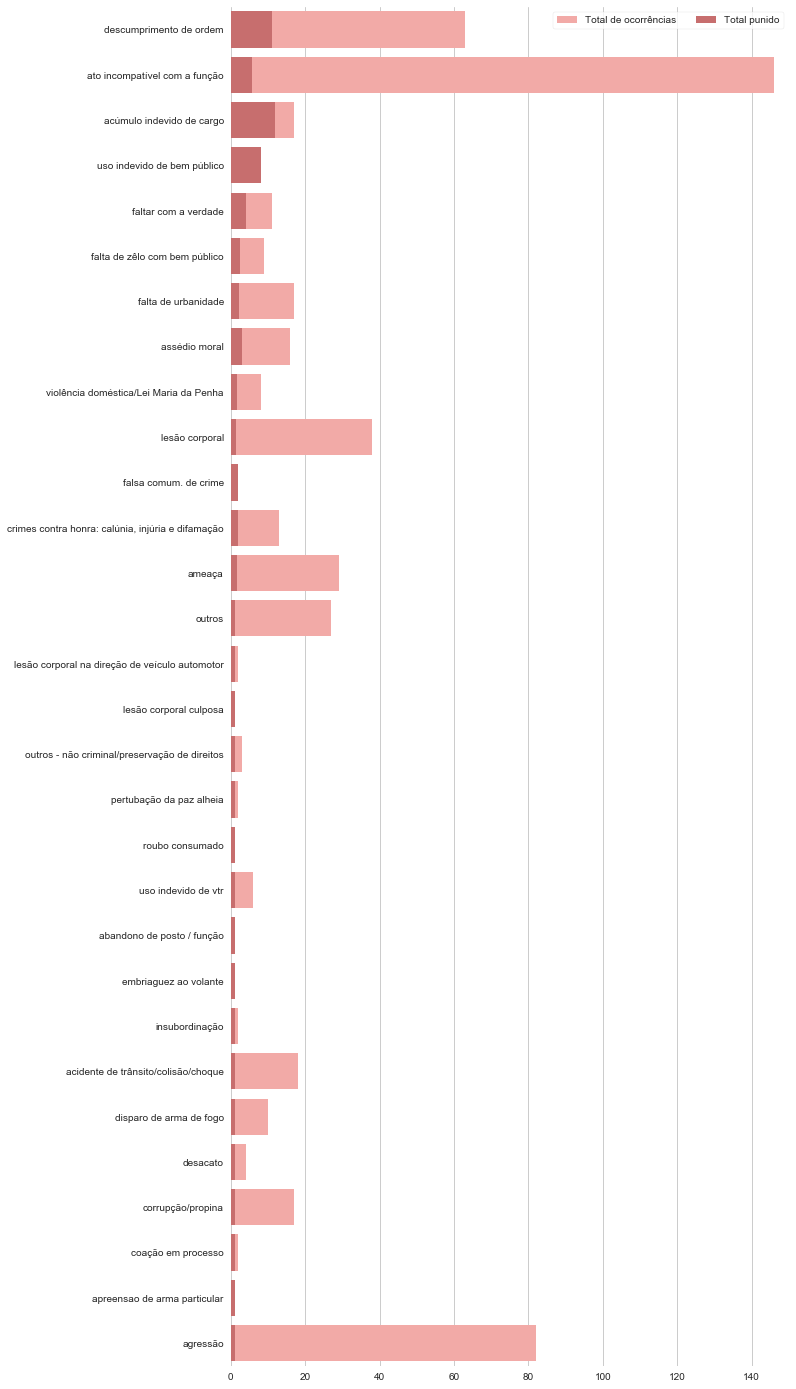

In [11]:
# Seleção das ocorrências punidas
sind_final_punido = sind_final[sind_final['punido'] == 'Sim']

# Criação de gráfico
ordena_sind = sind_final_punido.sort_values('quantidade', 
                                            ascending=False)
sns.set(style='whitegrid')
f, ax = plt.subplots(figsize = (10, 25))
sns.set_color_codes('pastel')
sns.barplot(x = 'chave', 
            y = 'natureza', 
            data = ordena_sind,
            label = 'Total de ocorrências', 
            color = 'r', 
            ci = None)
sns.set_color_codes('muted')
sns.barplot(x = 'quantidade', 
            y = 'natureza', 
            data = ordena_sind,
            label = 'Total punido', 
            color = 'r', 
            ci = None)
ax.legend(ncol = 2, 
          loc = 'upper right', 
          frameon = True)
ax.set(xlim = (0, 150), 
       ylabel = '',
       xlabel = '')
sns.despine(left=True, bottom=True)

In [12]:
# Recorte de todos os processos que não estão em andamento
inq_corte = inq_ate_setembro[inq_ate_setembro['penalidade'] != 'EM ANDAMENTO']

# Contagem de ocorrências por motivo (para fazer a porcentagem depois)
inq_corte['chave'] = inq_corte.groupby(['natureza'])['natureza']\
                              .transform('count')

# Agrupamento dos dados por motivo e punição
inq_final = inq_corte.groupby(['natureza', 'penalidade', 'chave'])['punido'].value_counts()

# Transformação em DataFrame
inq_final = pd.DataFrame(inq_final).rename(columns = {'punido': 'quantidade'}).reset_index()

# Definição da porcentagem
inq_final['porcentagem'] = (inq_final['quantidade'] / inq_final['chave'])

# Dispensa da coluna 'chave'
# inq_final = inq_final.drop('chave', axis = 1)

# Ordenação alfabética
inq_final = inq_final.sort_values('natureza', ascending = True)

# Resultado
inq_final

,natureza,penalidade,chave,punido,quantidade,porcentagem
0,abandono de posto / função,DECISÃO EM OUTRO PA,5.0,Incerto,1,0.200000
1,abandono de posto / função,SUSPENSÃO,5.0,Sim,4,0.800000
2,abuso de autoridade / poder,ARQUIVAMENTO,1.0,Não,1,1.000000
3,acúmulo indevido de cargo,DEMISSÃO,2.0,Sim,1,0.500000
4,acúmulo indevido de cargo,SUSPENSÃO,2.0,Sim,1,0.500000
5,adulteração de sinal de veículo automotor,SUSPENSÃO,1.0,Sim,1,1.000000
6,agressão,SUSPENSÃO,1.0,Sim,1,1.000000
9,ameaça,SUSPENSÃO,4.0,Sim,1,0.250000
8,ameaça,DEMISSÃO,4.0,Sim,2,0.500000
7,ameaça,ABSOLVIÇÃO,4.0,Não,1,0.250000


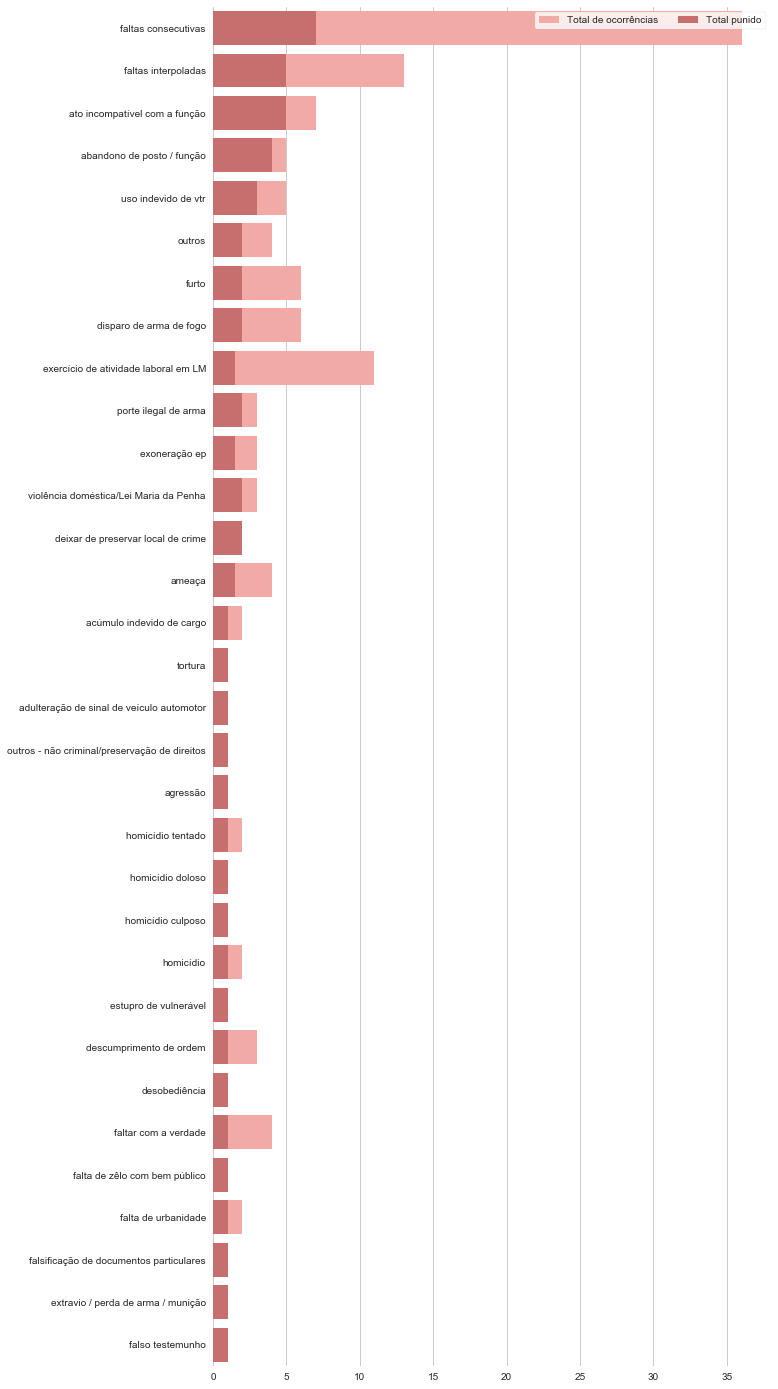

In [13]:
# Seleção das ocorrências punidas
inq_final_punido = inq_final[inq_final['punido'] == 'Sim']

# Criação de gráfico
ordena_inq = inq_final_punido.sort_values('quantidade', 
                                          ascending=False)
sns.set(style='whitegrid')
f, ax = plt.subplots(figsize = (10, 25))
sns.set_color_codes('pastel')
sns.barplot(x = 'chave', 
            y = 'natureza', 
            data = ordena_inq,
            label = 'Total de ocorrências', 
            color = 'r', 
            ci = None)
sns.set_color_codes('muted')
sns.barplot(x = 'quantidade', 
            y = 'natureza', 
            data = ordena_inq,
            label = 'Total punido', 
            color = 'r', 
            ci = None)
ax.legend(ncol = 2, 
          loc = 'upper right', 
          frameon = True)
ax.set(xlim = (0, 38), 
       ylabel = '',
       xlabel = '')
sns.despine(left=True, bottom=True)

In [14]:
# Gravação em .csv
pas_data_limite.to_csv('gcm_resultados.csv', 
                       sep = ';', 
                       encoding = 'latin-1', 
                       index = False)